In [1]:
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm

In [2]:
from aeolus.coord import add_cyclic_point_to_cube, replace_z_coord
from aeolus.plot import subplot_label_generator

In [3]:
from util_commons import EXPERIMENTS, GASES, LAYERS, SEASONS
from util_mypaths import path_to_processed, path_to_results
from util_plot_func import m_to_km, use_paper_style
from util_proc_func import mmr_to_vmr_in_ppn

In [4]:
warnings.filterwarnings("ignore", module="iris")
use_paper_style()

In [5]:
# List of chemical species to consider
SPECIES = [
#     "ch4",
#     "c2h6",
#     "c3h8",
    "no",
    "no2",
    "hono",
    "ho2no2",
    "hno3",
    "n2o5",
    "pan",
    "ppan",
    "meono2",
    "etono2",
    "nprono2",
    "iprono2",
    "o3",
]

In [6]:
# Switches
w_rono2 = True
xy = True
yz = False

In [7]:
# Read data
vrbls = {}
for exp in EXPERIMENTS.keys():
    vrbls[exp] = {}
    for sp in SPECIES:
        cube_in_mmr = iris.load_cube(
            str(path_to_processed / EXPERIMENTS[exp] / f"{EXPERIMENTS[exp]}_{sp}.nc"), sp
        )
        # Convert mass mixing ratio to volume mixing ratio
        cube_in_vmr = mmr_to_vmr_in_ppn(cube_in_mmr, GASES[sp]["molar_mass"], GASES[sp]["ppn"])
        # Replace model_level_number coordinate with level_height coordinate
        cube_on_hlevs = replace_z_coord(cube_in_vmr)
        cube_on_hlevs.rename(sp)
        cube_on_hlevs.units = GASES[sp]["ppn"]
        # Remove the first year as a spin up
        cube_on_hlevs = cube_on_hlevs[12::, ...]
        # Add season and year coordinates
        iris.coord_categorisation.add_season(cube_on_hlevs, "time", name="season")
        iris.coord_categorisation.add_season_year(cube_on_hlevs, "time", name="year")
        vrbls[exp][sp] = cube_on_hlevs

# Calculate NOx and NOy
for exp in EXPERIMENTS.keys():
    nox = vrbls[exp]["no"] + vrbls[exp]["no2"]
    noy = (
        nox
        + vrbls[exp]["hono"]
        + vrbls[exp]["ho2no2"]
        + vrbls[exp]["hno3"]
        + vrbls[exp]["n2o5"]
        + vrbls[exp]["pan"]
        + vrbls[exp]["ppan"]
    )
    # Include RONO2 into NOy?
    if w_rono2:
        rono2 = (
            vrbls[exp]["meono2"]
            + vrbls[exp]["etono2"]
            + vrbls[exp]["nprono2"]
            + vrbls[exp]["iprono2"]
        )
        rono2.convert_units("ppbv")
        noy = noy + rono2
    nox.rename("nox")
    noy.rename("noy")
    nox.units = "ppbv"
    noy.units = "ppbv"
    vrbls[exp]["nox"] = nox
    vrbls[exp]["noy"] = noy

### Layer seasonal mean maps

In [8]:
def plt_ssn_maps(var, layer, ctrl_dict):
    """Plot seasonal mean distribution of a chosen variable in a chosen layer.

    (Left column) shows the distribution in the control experiment,
    (middle column) absolute difference between the sensitivity and control experiment,
    (right column) relative difference between the sensitivity and control experiment.
    Stippling shows the areas where the difference is not statistically significant."""
    iletters = subplot_label_generator()

    lons = ctrl_dict[var]["djf"]["ssn_mean"].coord("longitude").points
    lats = ctrl_dict[var]["djf"]["ssn_mean"].coord("latitude").points

    if var == "o3":
        ssn_mean_levs = np.arange(0, 110, 10)
        ssn_mean_diff_abs_levs = np.arange(-10, 12, 2)
        ssn_mean_diff_pct_levs = np.arange(-40, 50, 10)
    elif var in ["nox", "hno3", "pan", "hono", "ho2no2", "n2o5", "ppan"]:
        ssn_mean_levs = np.arange(-4, 3, 1)
        ssn_mean_diff_abs_levs = np.arange(-1.25, 1.50, 0.25)
        ssn_mean_diff_pct_levs = np.arange(-200, 220, 20)
    elif var in ["meono2"]:
        ssn_mean_levs = np.arange(0, 50, 5)
        ssn_mean_diff_abs_levs = np.arange(-5, 10, 5)
        ssn_mean_diff_pct_levs = np.arange(-100, 110, 10)

    map_kws = dict(transform=ccrs.PlateCarree())
    cax_kw = dict(orientation="horizontal")
    ssn_mean_kws = dict(cmap="viridis", levels=ssn_mean_levs, **map_kws, extend="max")
    ssn_mean_diff_abs_kws = dict(
        cmap="RdBu_r", levels=ssn_mean_diff_abs_levs, **map_kws, extend="both"
    )
    ssn_mean_diff_pct_kws = dict(
        cmap="RdBu_r", levels=ssn_mean_diff_pct_levs, **map_kws, extend="both"
    )
    pval_kws = dict(s=1, c="grey", marker=".", alpha=1, **map_kws)

    fig, ax = plt.subplots(
        nrows=4,
        ncols=3,
        figsize=(20, 20),
        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)),
        facecolor="w",
    )
    for ssn, iax in zip(SEASONS.keys(), ax[:, 0].flatten()):
        if var in ["o3", "meono2"]:
            p0 = iax.contourf(lons, lats, ctrl_dict[var][ssn]["ssn_mean"].data, **ssn_mean_kws)
        else:
            ctrl_ssn_mean = iris.analysis.maths.log10(
                ctrl_dict[var][ssn]["ssn_mean"], in_place=False
            )
            p0 = iax.contourf(
                lons,
                lats,
                ctrl_ssn_mean.data,
                **ssn_mean_kws,
            )
        if iax.is_first_row():
            iax.set_title("CTRL", loc="center", weight="bold")
#         iax.annotate(f"         {ssn.upper()}", xy=(0, 1), xycoords="axes fraction", weight="bold")


    for iax in ax.flatten():
#         iax.set_title(f"({next(iletters)})", loc="left")
        iax.set_global()
        iax.coastlines()
    for ssn, iax in zip(SEASONS.keys(), ax[:, 2].flatten()):
        if iax.is_last_col():
            iax.annotate(f"         {ssn.upper()}", xy=(0, 1), xycoords="axes fraction", weight="bold")
    fig.subplots_adjust(hspace=-0.6, wspace=0.02)
    cax0 = fig.add_axes([0.185, 0.22, 0.135, 0.005])  # [left, bottom, width, height]
    cax1 = fig.add_axes([0.446, 0.22, 0.135, 0.005])
    cax2 = fig.add_axes([0.706, 0.22, 0.135, 0.005])
    cbar0 = fig.colorbar(p0, cax=cax0, label=f"{GASES[var]['tex']} [{GASES[var]['ppn']}]", **cax_kw)
    if var == "nox":
        cbar0.ax.set_xticklabels(
            ["$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$"]
        )
    fig.colorbar(p1, cax=cax1, label=f"$\Delta${GASES[var]['tex']} [{GASES[var]['ppn']}]", **cax_kw)
    fig.colorbar(p2, cax=cax2, label=f"$\Delta${GASES[var]['tex']} [%]", **cax_kw)
#     fig.suptitle(LAYERS[layer]["tex"], x=0.5125, y=0.8, weight="bold")
#     fig.savefig(
#         path_to_results
#         / "xojn"
#         / "ssn_mean_xy"
#         / "draft"
#         / f"{'CTRL'.lower()}_{var}_ssn_mean_xy_{layer}_210908.png"
#     )

NameError: name 'p1' is not defined

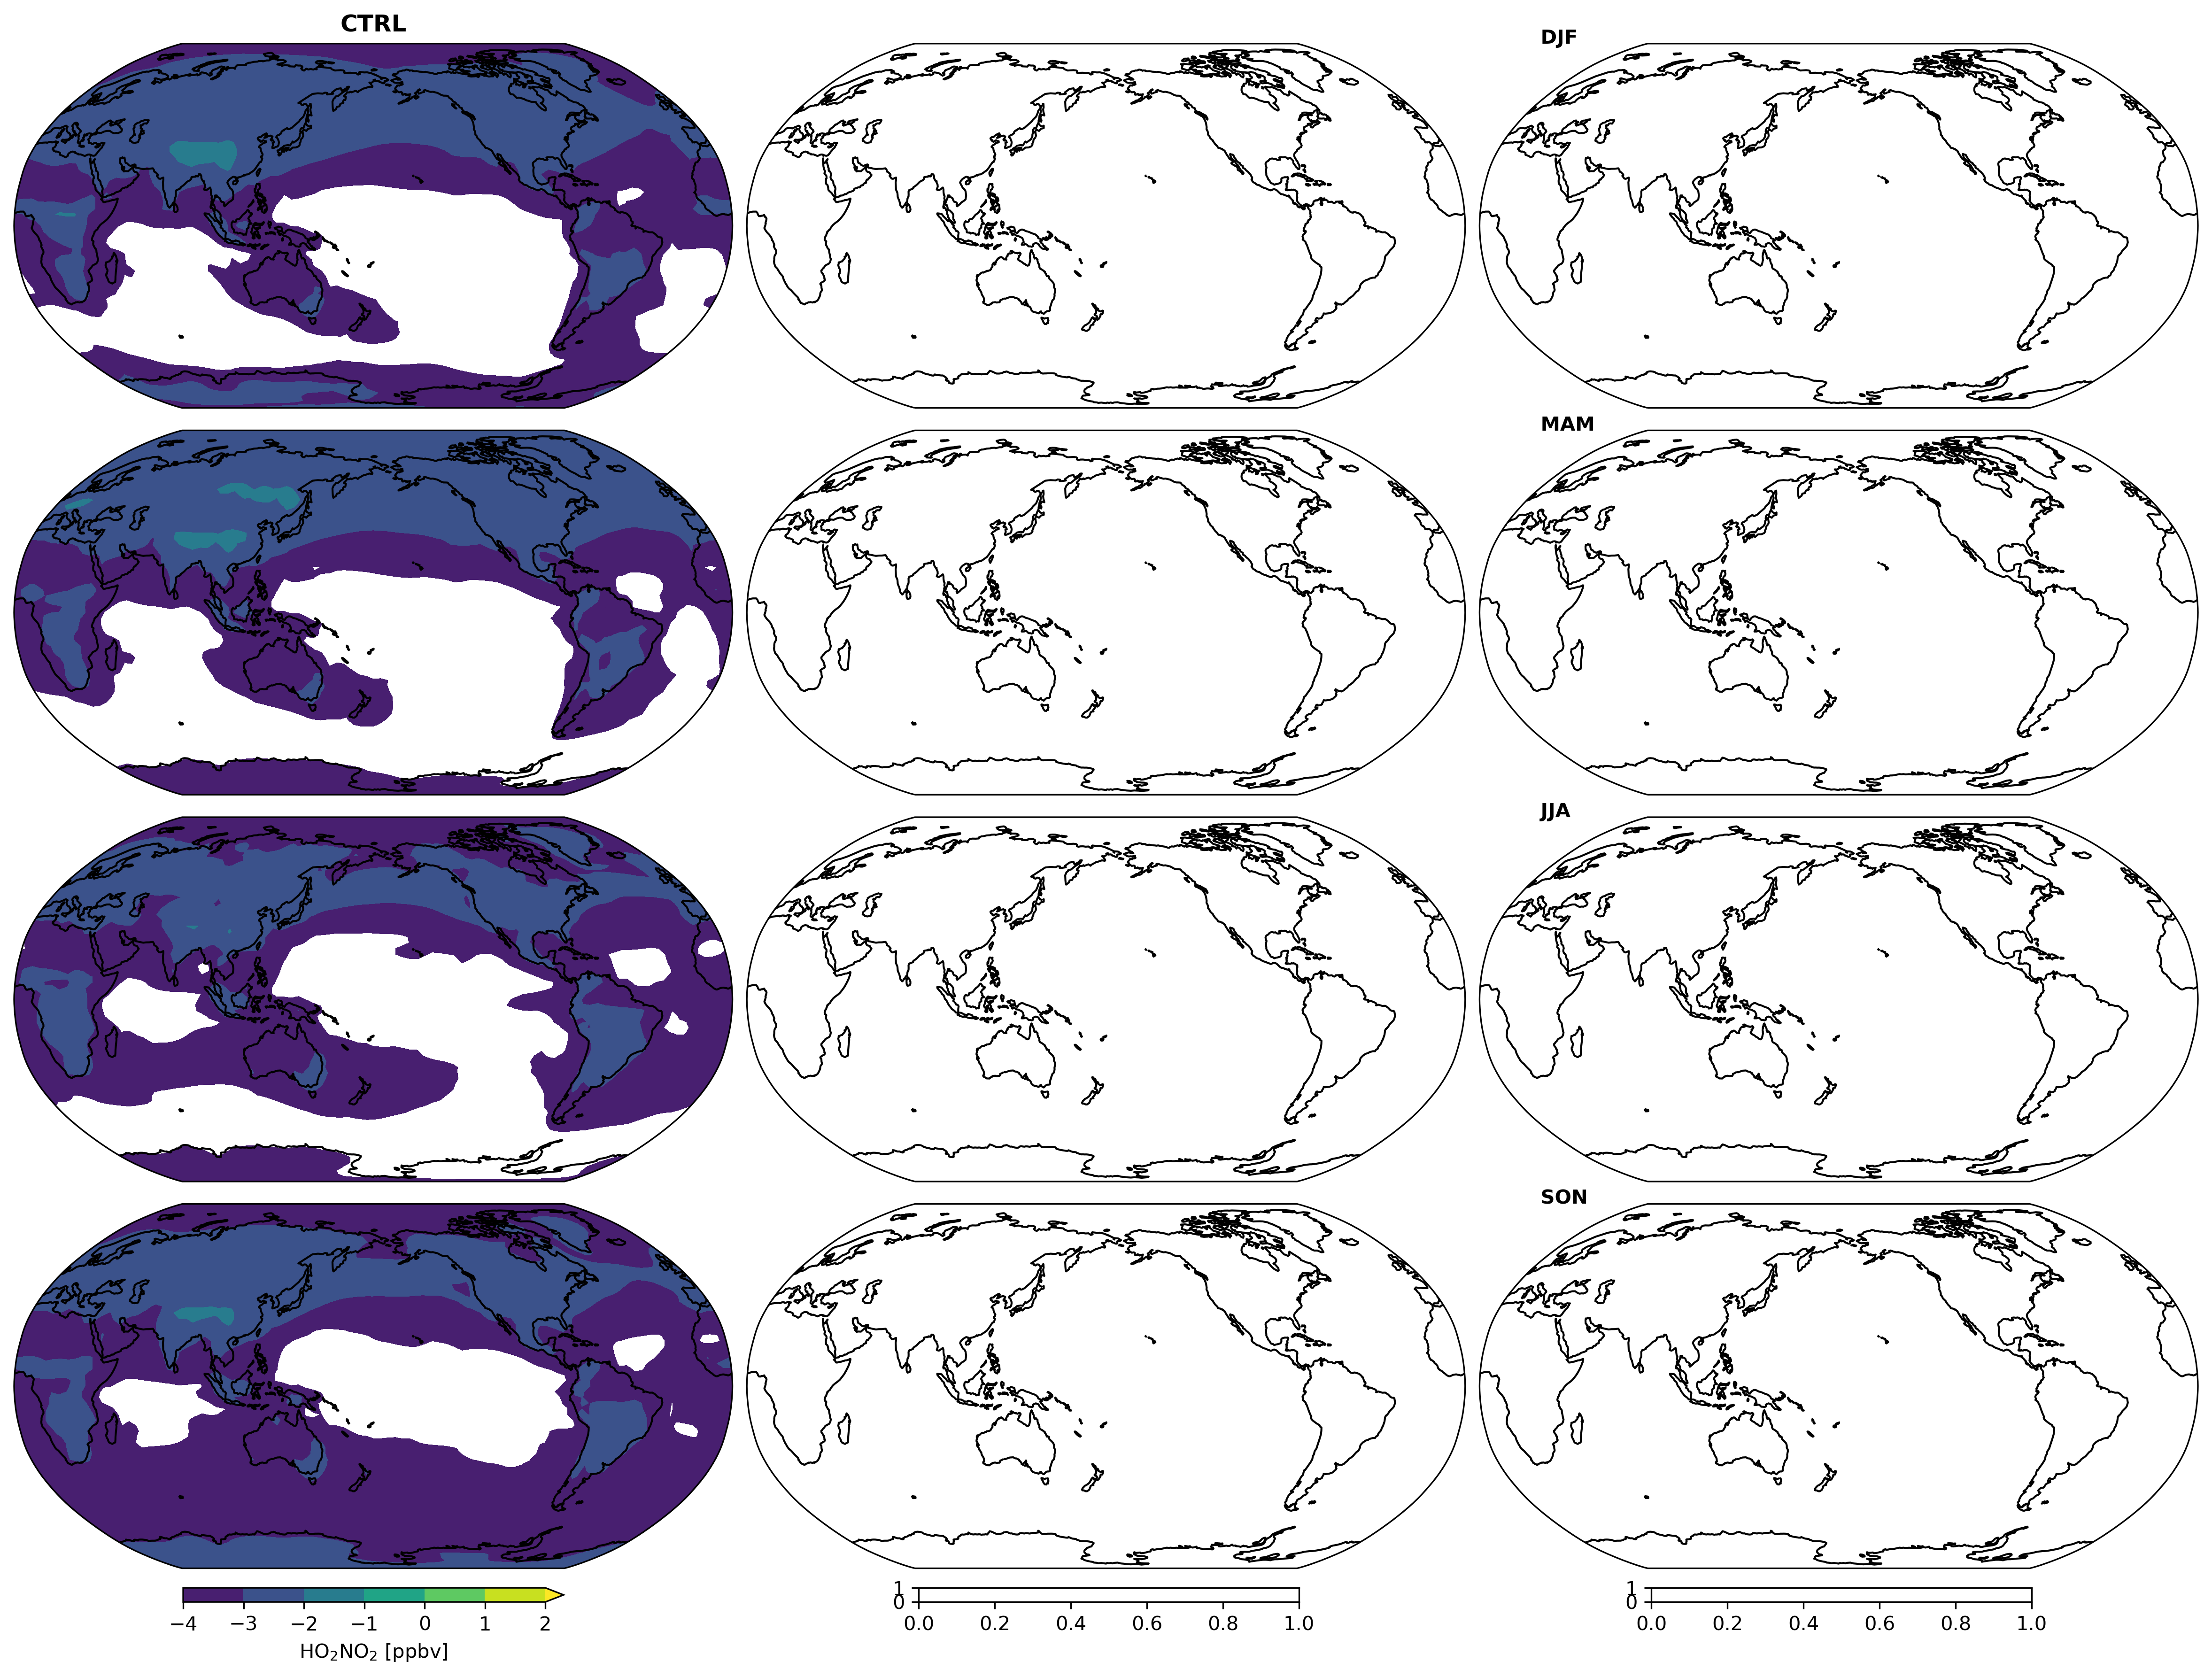

In [9]:
if xy:
    # Choose atmospheric layer
    layer = "5-10km"  # 0-2km 5-10km 0-17km 0-85km

    # Calculate 9-year-average seasonal mean in a chosen atmospheric layer
    VRBLS = {}
    for exp in EXPERIMENTS.keys():
        VRBLS[exp] = {}
        for var in [
            "ho2no2"
        ]:  # vrbls[exp].keys(): "o3", "nox", "hono", "ho2no2", "hno3", "n2o5", "pan", "ppan"
            VRBLS[exp][var] = {}
            for ssn in SEASONS.keys():
                # Extract a time series for each latitude-longitude within a layer by season
                # and average each time slice in height
                ssn_ts = (
                    vrbls[exp][var]
                    .extract(LAYERS[layer]["iris_constr"] & SEASONS[ssn]["iris_constr"])
                    .collapsed(["level_height"], iris.analysis.MEAN)
                )
                # Calculate 9-year-average seasonal mean
                _ssn_mean = ssn_ts.collapsed("year", iris.analysis.MEAN)
                # Add a cyclic point for plotting
                ssn_mean = add_cyclic_point_to_cube(_ssn_mean)
                # Find minimum and maximum
                ssn_mean_min, ssn_mean_max = ssn_mean.data.min(), ssn_mean.data.max()
                # Assemble data
                VRBLS[exp][var][ssn] = {
                    "ssn_ts": ssn_ts,
                    "ssn_mean": ssn_mean,
                    "ssn_mean_min": ssn_mean_min,
                    "ssn_mean_max": ssn_mean_max,
                }

    # Find common extrema for plotting
    var_lims = {}
    for var in ["ho2no2"]:
        var_lims[var] = {}
        ssn_mean_min_com = []
        ssn_mean_max_com = []
        for ssn in SEASONS.keys():
            ssn_mean_min_com.append(VRBLS["FULL"][var][ssn]["ssn_mean_min"])
            ssn_mean_max_com.append(VRBLS["FULL"][var][ssn]["ssn_mean_max"])
        var_lims[var] = {
            "ssn_mean_min_com": np.min(ssn_mean_min_com),
            "ssn_mean_max_com": np.max(ssn_mean_max_com),
        }

    # Plot
    ctrl_dict = VRBLS["FULL"]
    for var in ["ho2no2"]:
        plt_ssn_maps(var, layer, ctrl_dict)